In [104]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [105]:
def TickerIntoTensor(ticker='aapl',daysago=100,daysforward=1,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-daysforward-1,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(daysforward).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
    if split_percentage == -1:
        split = -1
    else:
        split = int(len(X)*split_percentage)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1))
    if daysforward == 1:
        Y_train, Y_test = Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
    else:
        Y_train, Y_test = Y_train.reshape((-1,daysforward)), Y_test.reshape((-1,daysforward))
    return X_train, X_test, Y_train, Y_test
TickerIntoTensor()

(array([[[3.09577133e-04],
         [2.83417229e-04],
         [2.48533600e-04],
         ...,
         [2.72370338e-04],
         [2.60346329e-04],
         [2.62051700e-04]],
 
        [[2.83417229e-04],
         [2.48533600e-04],
         [2.59433760e-04],
         ...,
         [2.60442474e-04],
         [2.66308145e-04],
         [2.65962685e-04]],
 
        [[2.48533600e-04],
         [2.59433760e-04],
         [2.72517521e-04],
         ...,
         [2.66406492e-04],
         [2.70282655e-04],
         [2.56185173e-04]],
 
        ...,
 
        [[2.74914287e-01],
         [2.78138553e-01],
         [2.81890018e-01],
         ...,
         [3.07081876e-01],
         [3.35563802e-01],
         [3.19708116e-01]],
 
        [[2.78138553e-01],
         [2.81890018e-01],
         [2.89392948e-01],
         ...,
         [3.35687725e-01],
         [3.24901060e-01],
         [3.34545610e-01]],
 
        [[2.81890018e-01],
         [2.89392948e-01],
         [2.88976067e-01],
         

In [106]:

daysago = 100
daysforward = 2
e = TickerIntoTensor('aapl', daysago, daysforward)
X_train, X_test, Y_train, Y_test = e[0], e[1], e[2], e[3]


model1 = Sequential()
model1.add(InputLayer((daysago+1, 1)))
model1.add(LSTM(daysago*daysforward))
model1.add(Dense(daysago, 'sigmoid'))
model1.add(Dense(daysforward, 'linear'))

cp1 = ModelCheckpoint('model/.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32, callbacks=[cp1])

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 0.1232 - root_mean_squared_error: 0.2941 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1415
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - loss: 1.6587e-05 - root_mean_squared_error: 0.0041 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 1.2007e-05 - root_mean_squared_error: 0.0035 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 1.1570e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 1.5495e-05 - root_mean_squared_error: 0.0039 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 1.7854e-05 - root_mean_squared_error: 0.0042 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 7/10
306/306 ━

In [107]:
from tensorflow.keras.models import load_model
model1 = load_model('model/.keras')
y_pred = model1.predict(TickerIntoTensor('goog',daysago,daysforward,0.8)[1])
Y_test = TickerIntoTensor('goog',daysago,daysforward,0.8)[3].reshape(-1,daysforward)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100

print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
4.199949880524813
-2.4542382680274573


In [108]:
4.020466543459491
-1.8923624028599568
6.006108272868733
-5.396731573550026
3.689409123745593
-2.90559122619576

-2.90559122619576

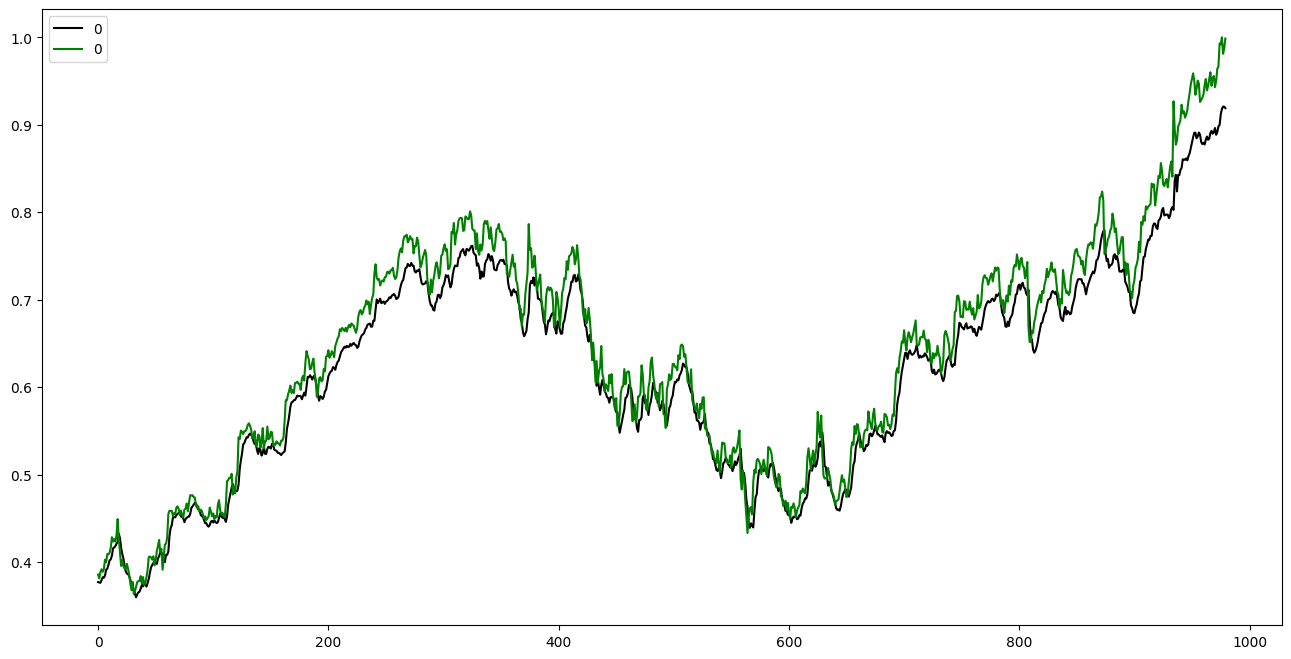

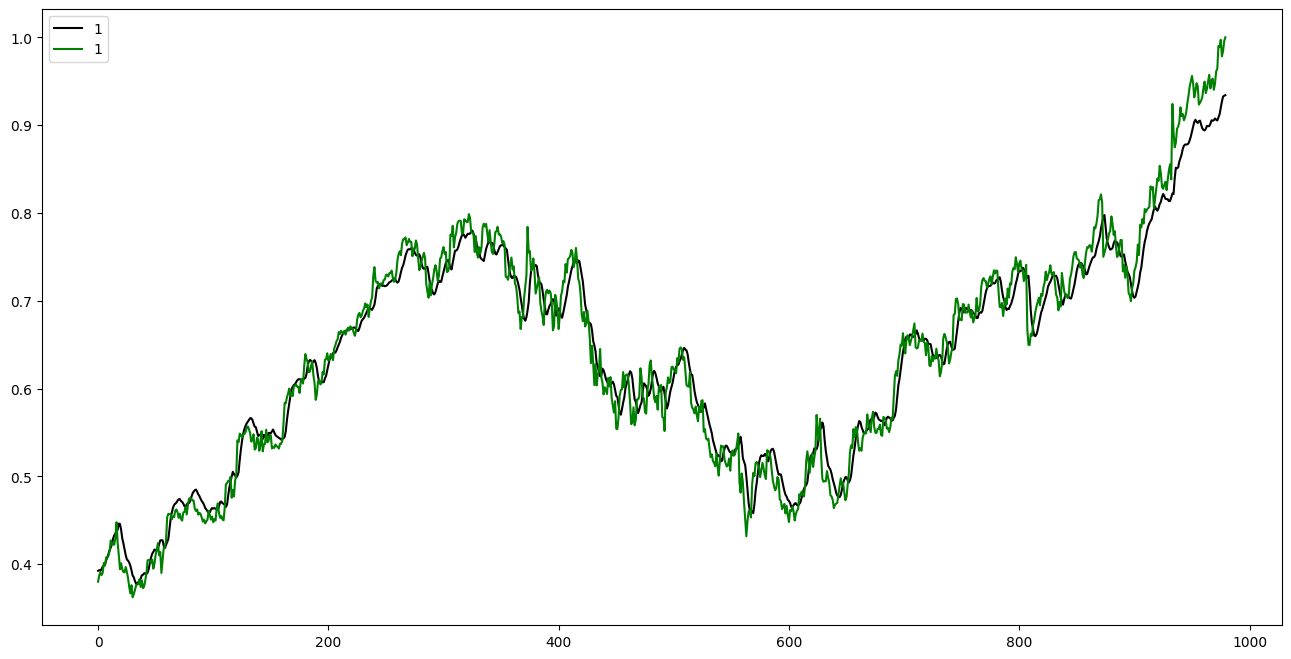

In [109]:
y_pred,Y_test = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('black','green'))
    

In [110]:
def UserInput_Two(ticker='aapl',daysago=100,futureproj=20):
    X_test = TickerIntoTensor(ticker,daysago,1,-1)[1]
    y_pred_proj = []
    for i in range(1,futureproj+1):
        y_pred = model1.predict(X_test)
        y_pred_proj = np.append(y_pred_proj,y_pred)
        X_test = X_test.reshape((-1))
        X_test = np.append(X_test, y_pred)
        #X_test = X_test[1:]
        X_test = X_test.reshape((-1,daysago+1+i,1))
    return y_pred_proj 


e = pd.DataFrame(UserInput_Two('nvda',100,1000))
e.plot(figsize=(16,8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ValueError: cannot reshape array of size 103 into shape (102,1)